In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

In [2]:
train_accounts = pd.read_csv('train_accounts.csv')
test_accounts = pd.read_csv('test_accounts.csv')
transactions = pd.read_csv('transactions.csv')

In [7]:
transactions

,from_account,to_account,transaction_time_utc,value,gas,gas_price
0,a00996,b31499,2020-05-04 14:54:03,0,72585,11500000000
1,a07890,b31500,2020-05-04 14:55:06,0,54426,11349723260
2,a22857,b31501,2020-05-04 14:55:23,0,200000,14024584890
3,a07890,b31502,2020-05-04 14:55:23,108900000000000000,21000,11349723260
4,a21390,b31501,2020-05-04 14:56:05,0,149999,32000000000
...,...,...,...,...,...,...
5826599,b37259,a16395,2020-05-04 13:20:57,2000000000000000,21000,8000000000
5826600,a18542,b31501,2020-05-04 13:21:32,0,60000,10800001235
5826601,a20151,b966524,2020-05-04 13:21:32,13000000000000000,21000,10800001235
5826602,a25907,b31505,2020-05-04 13:22:10,0,1500000,12000000000


In [8]:
transactions.value = transactions.value.astype(float)
transactions['transaction_time_utc'] = pd.to_datetime(transactions['transaction_time_utc'], 
                                                      format='%Y-%m-%d %H:%M:%S')

transactions['gas_fee'] = transactions['gas'] * transactions['gas_price']


train_accounts_sending = transactions[transactions['from_account'].isin(train_accounts.account)]
train_accounts_receiving = transactions[transactions['to_account'].isin(train_accounts.account)]

account_sending_ct = train_accounts_sending.groupby(['from_account'])['from_account'].count().to_frame()
account_receiving_ct = train_accounts_receiving.groupby(['to_account'])['to_account'].count().to_frame()
account_sending_ct.columns = ['n_sending']
account_receiving_ct.columns = ['n_receiving']
account_sending_ct = account_sending_ct.reset_index()
account_receiving_ct = account_receiving_ct.reset_index()
account_sending_ct = account_sending_ct.rename(columns={"from_account": "account"})
account_receiving_ct = account_receiving_ct.rename(columns={"to_account": "account"})

trans_groupby_sending = train_accounts_sending.groupby('from_account', as_index=False).agg({'to_account':'nunique', 'value':'sum', 'gas_fee':'sum'})
trans_groupby_receiving = train_accounts_receiving.groupby('to_account', as_index=False)\
                                              .agg({'from_account':'nunique', 
                                                    'value':'sum', 'gas_fee':'sum'})

trans_groupby_sending = trans_groupby_sending.rename(columns={"from_account": "account",
                                                              'to_account':'n_sending_to_accounts',
                                                              "value":"sending_value",
                                                             "gas_fee":"sending_gas_fee"})
trans_groupby_receiving = trans_groupby_receiving.rename(columns={"to_account": "account",
                                                                  'from_account':'n_receiving_from_accounts',
                                                                  "value":"receiving_value",
                                                             "gas_fee":"receiving_gas_fee"})

train_accounts = train_accounts.merge(account_sending_ct, on='account', how='left')\
.merge(account_receiving_ct, on='account', how='left')\
.merge(trans_groupby_receiving, on='account', how='left')\
.merge(trans_groupby_sending, on='account', how='left')

train_accounts = train_accounts.fillna(0)

In [13]:
train_accounts['ratio_receiving_account'] = train_accounts['n_receiving'] / train_accounts['n_receiving_from_accounts']
train_accounts['ratio_sending_account'] = train_accounts['n_sending'] / train_accounts['n_sending_to_accounts']

train_accounts = train_accounts.fillna(0)

In [62]:
transactions.dtypes

from_account            object
to_account              object
transaction_time_utc    object
value                   object
gas                      int64
gas_price                int64
dtype: object

In [65]:
transactions.describe() # more than half token transfer

,value,gas,gas_price,gas_fee
count,5.826604e+06,5.826604e+06,5.826604e+06,5.826604e+06
mean,2.788427e+18,2.450964e+05,5.544367e+10,1.502509e+16
std,9.682803e+19,5.374690e+05,2.084319e+11,7.070427e+16
min,0.000000e+00,2.100000e+04,0.000000e+00,-9.217154e+18
25%,0.000000e+00,5.000000e+04,6.000000e+09,4.590000e+14
50%,0.000000e+00,9.000000e+04,2.000000e+10,1.890000e+15
75%,5.098727e+16,2.500000e+05,6.000000e+10,9.000000e+15
max,5.850000e+22,1.202223e+07,1.713970e+14,8.983450e+18


In [16]:
len(train_accounts[train_accounts.flag == 0])

22743

In [17]:
len(train_accounts[train_accounts.flag == 1]) # need oversampling

2455

In [223]:
len(transactions)

5826604

In [70]:
len(train_accounts_sending)

2205349

In [71]:
len(train_accounts_receiving)

2495749

In [72]:
len(list(set(train_accounts_sending.from_account)))

23371

In [73]:
len(list(set(train_accounts_receiving.to_account)))

24697

In [74]:
train_accounts_having_transac_history = list(set()\
                                             .union(list(set(train_accounts_receiving.to_account)),\
                                                   list(set(train_accounts_sending.from_account))))

In [75]:
len(train_accounts_having_transac_history) 

25198

In [76]:
len(train_accounts)

25198

In [77]:
transactions.head()

,from_account,to_account,transaction_time_utc,value,gas,gas_price,gas_fee
0,a00996,b31499,2020-05-04 14:54:03,0.000000e+00,72585,11500000000,834727500000000
1,a07890,b31500,2020-05-04 14:55:06,0.000000e+00,54426,11349723260,617720038148760
2,a22857,b31501,2020-05-04 14:55:23,0.000000e+00,200000,14024584890,2804916978000000
3,a07890,b31502,2020-05-04 14:55:23,1.089000e+17,21000,11349723260,238344188460000
4,a21390,b31501,2020-05-04 14:56:05,0.000000e+00,149999,32000000000,4799968000000000


In [9]:
train_accounts_receiving = train_accounts_receiving.sort_values(by='transaction_time_utc')
receiving_mean_time_between_trans = train_accounts_receiving.groupby('to_account', as_index=False)\
                        .agg({'transaction_time_utc': lambda x: x.diff().astype('timedelta64[m]').mean()})

train_accounts_sending = train_accounts_sending.sort_values(by='transaction_time_utc')
sending_mean_time_between_trans = train_accounts_sending.groupby('from_account', as_index=False)\
                        .agg({'transaction_time_utc': lambda x: x.diff().astype('timedelta64[m]').mean()})

receiving_mean_time_between_trans = receiving_mean_time_between_trans.rename(columns={"to_account": "account",
                                                              'transaction_time_utc':'mean_time_between_receiving'})
sending_mean_time_between_trans = sending_mean_time_between_trans.rename(columns={"from_account": "account",
                                                              'transaction_time_utc':'mean_time_between_sending'})

In [10]:
train_accounts = train_accounts.merge(receiving_mean_time_between_trans, on='account', how='left')\
.merge(sending_mean_time_between_trans, on='account', how='left')

In [11]:
train_accounts = train_accounts.fillna(-1)

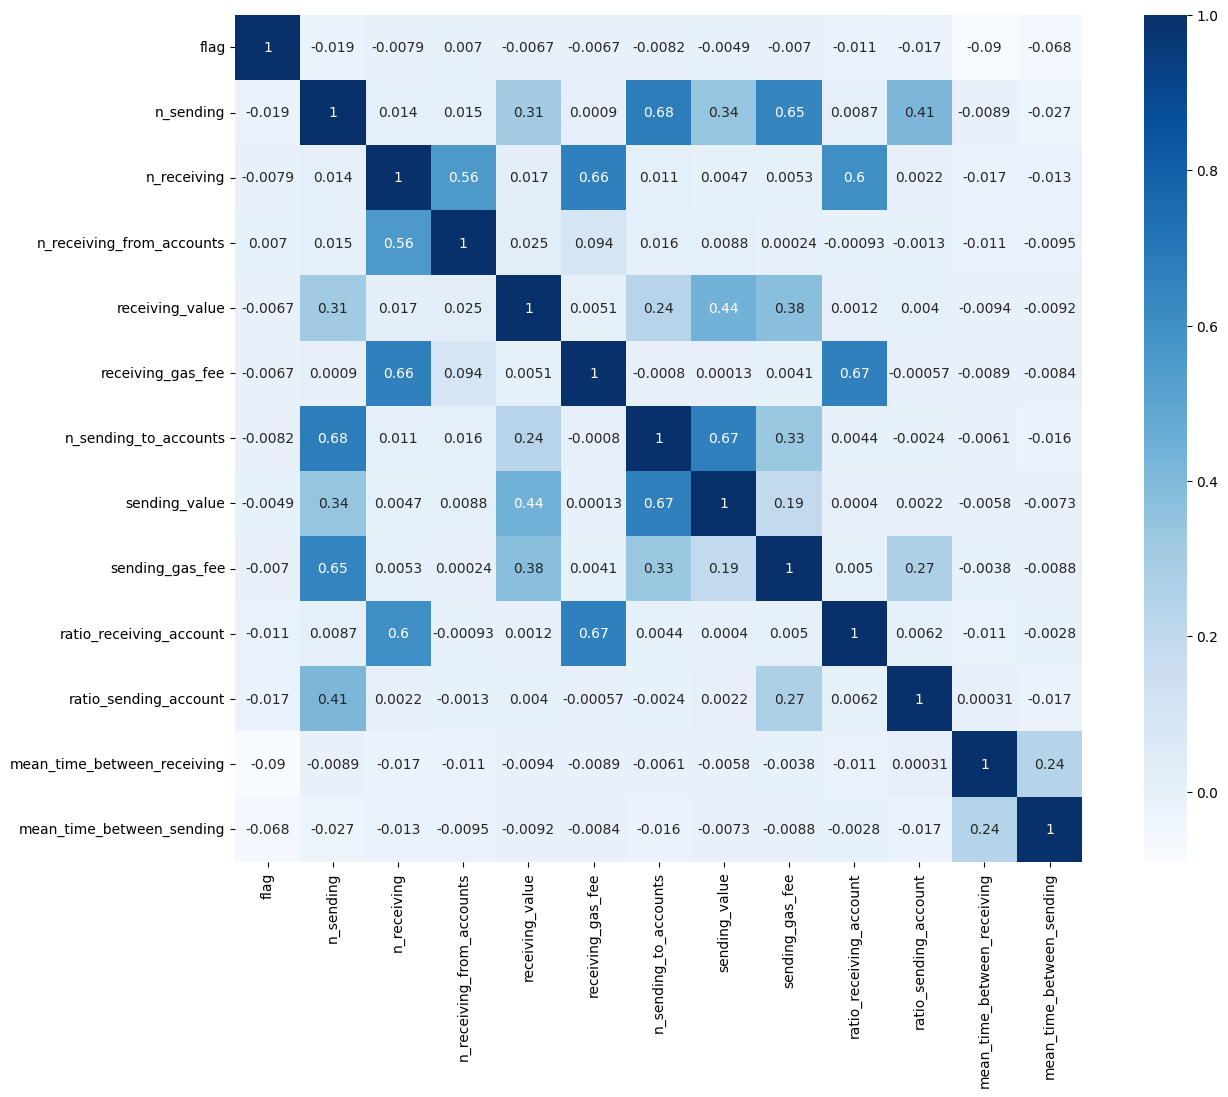

In [216]:
# correlation heatmap
corr_train_data = train_accounts.copy()
fig, ax = plt.subplots(figsize=(16,11))
corr = corr_train_data.corr()
sns.heatmap(corr, cmap="Blues", annot=True, square=True, ax = ax)
plt.yticks(rotation=0)
plt.show()

In [24]:
train_accounts.tail()

,account,flag,n_sending,n_receiving,n_receiving_from_accounts,receiving_value,receiving_gas_fee,n_sending_to_accounts,sending_value,sending_gas_fee,mean_time_between_receiving,mean_time_between_sending,ratio_receiving_account,ratio_sending_account
25193,a24443,0,12.0,13.0,1.0,8.478931e+16,4.929000e+17,1.0,0.000000e+00,2.805000e+17,6762.333333,7377.545455,13.000000,12.000000
25194,a12337,0,151.0,13.0,6.0,1.007616e+18,1.140900e+16,15.0,2.769889e+18,2.232801e+17,10224.166667,817.386667,2.166667,10.066667
25195,a08122,0,2.0,2.0,1.0,2.076600e+15,7.500000e+14,2.0,1.201300e+15,1.904840e+15,229.000000,5561.000000,2.000000,1.000000
25196,a27826,1,10.0,5.0,5.0,1.099792e+19,8.778000e+14,10.0,1.098596e+19,2.417362e+15,4342.250000,1843.222222,1.000000,1.000000
25197,a09863,1,18.0,14.0,13.0,2.021170e+20,5.523000e+15,13.0,2.021085e+20,8.442000e+15,23428.769231,18155.705882,1.076923,1.384615


In [15]:
X = train_accounts.drop(columns=['flag'])
y = train_accounts['flag']

X = X.set_index('account')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# oversampling using SMOTE
sm = SMOTE()
x_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
# train_data_oversampled = pd.concat([x_train_oversampled, y_train_oversampled], axis=1)

In [179]:
# logistics regression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_oversampled, y_train_oversampled)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9055555555555556


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [180]:
# predicted value 
y_hat_train_lr = logisticRegr.predict(x_train_oversampled)
y_hat_test_lr = logisticRegr.predict(X_test)

print(
    f'Accuracy Score \
    \nTrain: {accuracy_score(y_train_oversampled, y_hat_train_lr)} \
    \nTest: {accuracy_score(y_test, y_hat_test_lr)}'
)

Accuracy Score     
Train: 0.5     
Test: 0.9055555555555556


In [19]:
# random forest
rf = RandomForestClassifier(min_samples_split=2,random_state=0, n_estimators = 100, max_features=10, min_samples_leaf=1, criterion="gini")
rf.fit(x_train_oversampled, y_train_oversampled)

# predicted value 
y_hat_train_rf = rf.predict(x_train_oversampled)
y_hat_test_rf = rf.predict(X_test)

print(
    f'Accuracy Score \
    \nTrain: {accuracy_score(y_train_oversampled, y_hat_train_rf)} \
    \nTest: {accuracy_score(y_test, y_hat_test_rf)}'
)

Accuracy Score     
Train: 1.0     
Test: 0.9287698412698413


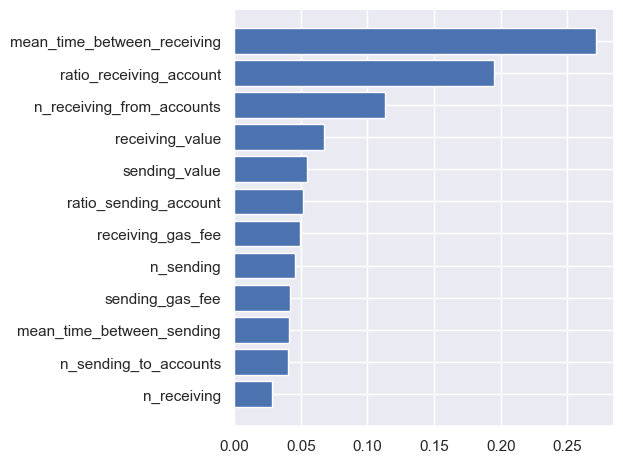

In [23]:

importances_rf = rf.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances_rf)[::]
sns.set_theme()
plt.barh(range(x_train_oversampled.shape[1]), importances_rf[sorted_indices], align='center')
plt.yticks(range(x_train_oversampled.shape[1]), x_train_oversampled.columns[sorted_indices])
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


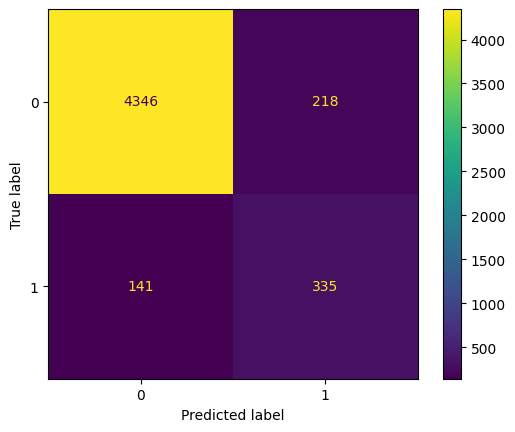

In [22]:
plot_confusion_matrix(rf, X_test, y_test)

In [182]:
y_hat_test_rf = pd.DataFrame(y_hat_test_rf, 
             columns=['predicted_flag'])

In [184]:
test_result = pd.concat([X_test, y_test.to_frame().set_index(X_test.index), y_hat_test_rf.set_index(X_test.index)], axis=1)

In [186]:
test_result[(test_result.flag == 0) & (test_result.predicted_flag == 1)]

,n_sending,n_receiving,n_receiving_from_accounts,receiving_value,receiving_gas_fee,n_sending_to_accounts,sending_value,sending_gas_fee,ratio_receiving_account,ratio_sending_account,mean_time_between_receiving,mean_time_between_sending,flag,predicted_flag
account,,,,,,,,,,,,,,
a26205,2.0,2.0,2.0,4.864631e+18,5.400000e+15,2.0,4.860631e+18,1.800000e+15,1.000000,1.000000,4683.000000,4973.000000,0,1
a10267,67.0,11.0,11.0,1.229942e+19,3.166706e+16,33.0,1.407166e+19,3.868488e+17,1.000000,2.030303,8743.500000,1455.121212,0,1
a29610,61.0,15.0,15.0,1.370120e+19,7.393890e+16,16.0,1.951183e+19,1.550266e+18,1.000000,3.812500,2723.928571,656.833333,0,1
a00480,0.0,78.0,19.0,1.827765e+20,1.523564e+17,0.0,0.000000e+00,0.000000e+00,4.105263,-1.000000,11595.415584,-1.000000,0,1
a19912,4.0,3.0,2.0,2.100700e+19,2.015440e+15,3.0,2.100627e+19,1.034200e+15,1.500000,1.333333,2552.500000,158736.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a19878,66.0,3.0,3.0,2.800000e+19,3.570000e+14,8.0,1.688317e+20,6.273468e+17,1.000000,8.250000,2942.500000,3800.169231,0,1
a18530,6.0,19.0,19.0,3.000114e+18,6.876366e+16,3.0,2.976368e+18,4.114800e+16,1.000000,2.000000,584.777778,939.800000,0,1
a20022,49.0,7.0,7.0,1.501124e+21,2.359605e+15,18.0,1.693799e+21,1.303816e+17,1.000000,2.722222,30295.166667,4185.520833,0,1


In [150]:
train_test = X_test.copy()

In [151]:
train_test = train_test.reset_index()
train_test['flag'] = y_test

In [152]:
train_test

,account,n_sending,n_receiving,n_receiving_from_accounts,receiving_value,receiving_gas_fee,n_sending_to_accounts,sending_value,sending_gas_fee,ratio_receiving_account,ratio_sending_account,mean_time_between_receiving,mean_time_between_sending,flag
0,a05097,1.0,1.0,1.0,1.700000e+16,2.050000e+14,1.0,1.569800e+16,1.302000e+15,1.000000,1.000000,-1.000000,-1.000000,NaN
1,a10876,24.0,11.0,6.0,1.712871e+16,4.935000e+14,19.0,1.578610e+16,2.134072e+15,1.833333,1.263158,78336.600000,34060.782609,NaN
2,a16551,0.0,1.0,1.0,4.016500e+15,7.560000e+14,0.0,0.000000e+00,0.000000e+00,1.000000,-1.000000,-1.000000,-1.000000,NaN
3,a09221,6.0,3.0,1.0,3.490000e+16,8.127000e+15,1.0,0.000000e+00,5.480000e+16,3.000000,6.000000,61303.500000,36003.000000,NaN
4,a19484,0.0,10.0,3.0,5.092805e+17,6.462400e+16,0.0,0.000000e+00,0.000000e+00,3.333333,-1.000000,48812.555556,-1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,a11426,0.0,2.0,2.0,1.108917e+18,4.065000e+15,0.0,0.000000e+00,0.000000e+00,1.000000,-1.000000,100.000000,-1.000000,1.0
5036,a18945,60.0,15.0,4.0,3.001000e+19,8.121300e+16,13.0,6.602908e+19,8.467275e+17,3.750000,4.615385,17483.285714,3972.661017,NaN
5037,a12893,33.0,2.0,1.0,5.165532e+16,6.253800e+15,12.0,2.961544e+18,1.660798e+17,2.000000,2.750000,124369.000000,3872.968750,NaN
5038,a09176,1.0,1.0,1.0,4.500000e+17,1.000000e+16,1.0,4.496430e+17,3.570000e+14,1.000000,1.000000,-1.000000,-1.000000,0.0


In [158]:
test_accounts_sending = transactions[transactions['from_account'].isin(test_accounts.account)]
test_accounts_receiving = transactions[transactions['to_account'].isin(test_accounts.account)]

account_sending_ct = test_accounts_sending.groupby(['from_account'])['from_account'].count().to_frame()
account_receiving_ct = test_accounts_receiving.groupby(['to_account'])['to_account'].count().to_frame()
account_sending_ct.columns = ['n_sending']
account_receiving_ct.columns = ['n_receiving']
account_sending_ct = account_sending_ct.reset_index()
account_receiving_ct = account_receiving_ct.reset_index()
account_sending_ct = account_sending_ct.rename(columns={"from_account": "account"})
account_receiving_ct = account_receiving_ct.rename(columns={"to_account": "account"})

trans_groupby_sending = test_accounts_sending.groupby('from_account', as_index=False)\
                                              .agg({'to_account':'nunique', 'value':'sum', 
                                                    'gas_fee':'sum'})
trans_groupby_receiving = test_accounts_receiving.groupby('to_account', as_index=False)\
                                              .agg({'from_account':'nunique', 
                                                    'value':'sum', 'gas_fee':'sum'})

trans_groupby_sending = trans_groupby_sending.rename(columns={"from_account": "account",
                                                              'to_account':'n_sending_to_accounts',
                                                              "value":"sending_value",
                                                             "gas_fee":"sending_gas_fee"})
trans_groupby_receiving = trans_groupby_receiving.rename(columns={"to_account": "account",
                                                                  'from_account':'n_receiving_from_accounts',
                                                                  "value":"receiving_value",
                                                             "gas_fee":"receiving_gas_fee"})

test_accounts = test_accounts.merge(account_sending_ct, on='account', how='left')\
.merge(account_receiving_ct, on='account', how='left')\
.merge(trans_groupby_receiving, on='account', how='left')\
.merge(trans_groupby_sending, on='account', how='left')

test_accounts['ratio_receiving_account'] = test_accounts['n_receiving'] / test_accounts['n_receiving_from_accounts']
test_accounts['ratio_sending_account'] = test_accounts['n_sending'] / test_accounts['n_sending_to_accounts']

test_accounts = test_accounts.fillna(0)

In [187]:
test_accounts

,account,n_sending,n_receiving,n_receiving_from_accounts,receiving_value,receiving_gas_fee,n_sending_to_accounts,sending_value,sending_gas_fee,ratio_receiving_account,ratio_sending_account,mean_time_between_receiving,mean_time_between_sending
0,a27890,0.0,26565.0,17864.0,2.525944e+18,6.911646e+18,0.0,0.000000e+00,0.000000e+00,1.487069,0.000000,35.417369,-1.000000
1,a29649,0.0,53110.0,15134.0,3.824075e+17,2.186946e+20,0.0,0.000000e+00,0.000000e+00,3.509317,0.000000,38.493720,-1.000000
2,a28243,0.0,40264.0,10277.0,2.000000e+15,1.234818e+20,0.0,0.000000e+00,0.000000e+00,3.917875,0.000000,28.179867,-1.000000
3,a07155,12566.0,5328.0,4.0,9.425000e+19,1.192017e+19,4.0,0.000000e+00,4.649287e+20,1332.000000,3141.500000,169.176272,71.500517
4,a15576,17553.0,67.0,58.0,1.184706e+19,1.562439e+16,85.0,5.830251e+18,1.436318e+19,1.155172,206.505882,10035.833333,51.373861
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,a19941,0.0,1.0,1.0,1.000000e+12,7.050000e+14,0.0,0.000000e+00,0.000000e+00,1.000000,0.000000,-1.000000,-1.000000
6296,a09327,1.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,6.807694e+16,8.190000e+13,0.000000,1.000000,-1.000000,-1.000000
6297,a10254,1.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,4.900000e+14,0.000000,1.000000,-1.000000,-1.000000
6298,a08928,1.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,9.951357e+15,0.000000,1.000000,-1.000000,-1.000000


In [162]:
test_accounts_receiving = test_accounts_receiving.sort_values(by='transaction_time_utc')
receiving_mean_time_between_trans = test_accounts_receiving.groupby('to_account', as_index=False)\
                        .agg({'transaction_time_utc': lambda x: x.diff().astype('timedelta64[m]').mean()})

test_accounts_sending = test_accounts_sending.sort_values(by='transaction_time_utc')
sending_mean_time_between_trans = test_accounts_sending.groupby('from_account', as_index=False)\
                        .agg({'transaction_time_utc': lambda x: x.diff().astype('timedelta64[m]').mean()})

receiving_mean_time_between_trans = receiving_mean_time_between_trans.rename(columns={"to_account": "account",
                                                              'transaction_time_utc':'mean_time_between_receiving'})
sending_mean_time_between_trans = sending_mean_time_between_trans.rename(columns={"from_account": "account",
                                                              'transaction_time_utc':'mean_time_between_sending'})
test_accounts = test_accounts.merge(receiving_mean_time_between_trans, on='account', how='left')\
.merge(sending_mean_time_between_trans, on='account', how='left')

test_accounts = test_accounts.fillna(-1)

In [188]:
test_acc = test_accounts.set_index('account')

In [189]:
test_acc

,n_sending,n_receiving,n_receiving_from_accounts,receiving_value,receiving_gas_fee,n_sending_to_accounts,sending_value,sending_gas_fee,ratio_receiving_account,ratio_sending_account,mean_time_between_receiving,mean_time_between_sending
account,,,,,,,,,,,,
a27890,0.0,26565.0,17864.0,2.525944e+18,6.911646e+18,0.0,0.000000e+00,0.000000e+00,1.487069,0.000000,35.417369,-1.000000
a29649,0.0,53110.0,15134.0,3.824075e+17,2.186946e+20,0.0,0.000000e+00,0.000000e+00,3.509317,0.000000,38.493720,-1.000000
a28243,0.0,40264.0,10277.0,2.000000e+15,1.234818e+20,0.0,0.000000e+00,0.000000e+00,3.917875,0.000000,28.179867,-1.000000
a07155,12566.0,5328.0,4.0,9.425000e+19,1.192017e+19,4.0,0.000000e+00,4.649287e+20,1332.000000,3141.500000,169.176272,71.500517
a15576,17553.0,67.0,58.0,1.184706e+19,1.562439e+16,85.0,5.830251e+18,1.436318e+19,1.155172,206.505882,10035.833333,51.373861
...,...,...,...,...,...,...,...,...,...,...,...,...
a19941,0.0,1.0,1.0,1.000000e+12,7.050000e+14,0.0,0.000000e+00,0.000000e+00,1.000000,0.000000,-1.000000,-1.000000
a09327,1.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,6.807694e+16,8.190000e+13,0.000000,1.000000,-1.000000,-1.000000
a10254,1.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,4.900000e+14,0.000000,1.000000,-1.000000,-1.000000


In [190]:
predicted_flag_for_test_rf = rf.predict(test_acc)

In [193]:
submit = pd.concat([test_acc, predicted_flag_for_test_rf.set_index(test_acc.index)], axis=1)

In [192]:
predicted_flag_for_test_rf = pd.DataFrame(predicted_flag_for_test_rf, 
             columns=['predicted_flag'])

In [195]:
submit = submit.reset_index()

In [198]:
submit = submit[['account', 'predicted_flag']]

In [201]:
submit.to_csv('submission.csv', index = False)

In [202]:
submit

,account,predicted_flag
0,a27890,0
1,a29649,0
2,a28243,0
3,a07155,0
4,a15576,0
...,...,...
6295,a19941,1
6296,a09327,0
6297,a10254,0
6298,a08928,0
